In [1]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram as original_dendrogram

# KEGG API base URL
KEGG_API_BASE = "http://rest.kegg.jp/"
def get_species_list(phylum):
    organism_url = KEGG_API_BASE + "list/organism"
    response = requests.get(organism_url)
    lines = response.text.split("\n")
    species_list = []

    for line in lines:
        if line and phylum in line:
            parts = line.split("\t")
            species_code = parts[1]
            species_name = parts[2]
            species_list.append((species_code, species_name))

    return species_list
def get_metabolic_pathways(species_code):
    pathways_url = KEGG_API_BASE + f"list/pathway/{species_code}"
    response = requests.get(pathways_url)
    lines = response.text.split("\n")

    pathways = []
    for line in lines:
        if line:
            parts = line.split("\t")
            pathway_id = parts[0]
            pathways.append(pathway_id)
    return pathways


def pathways_lists(species_code):
    pathways_url = KEGG_API_BASE + f"list/pathway/{species_code}"
    response = requests.get(pathways_url)
    lines = response.text.split("\n")
    pathways = {}
    for line in lines:
        if line:
            parts = line.split("\t")
            pathway_id = parts[0].replace(species_code, "")
            pathway_name = parts[1].split(" - ")[0]
            pathways[pathway_id] = pathway_name
    return pathways


def pathways_to_matrix(pathway_list, species_list):
    flattened_list = [item for sublist in pathway_list for item in sublist]
    prefixes = sorted(set([item[:item.find("0")] for item in flattened_list]))
    pathway_ids = sorted(set([item[item.find("0"):] for item in flattened_list]))

    matrix = np.zeros((len(prefixes), len(pathway_ids)))

    for pathway in flattened_list:
        prefix = pathway[:pathway.find("0")]
        pathway_id = pathway[pathway.find("0"):]
        row_idx = prefixes.index(prefix)
        col_idx = pathway_ids.index(pathway_id)
        matrix[row_idx][col_idx] = 1

    species_fullnames = [species_name for _, species_name in species_list]
    df = pd.DataFrame(matrix, index=species_fullnames, columns=pathway_ids)
    return df


def plot_heatmap(matrix, pathways_dict, output_pdf):
    # 根据通路数量动态调整图形的高度
    pathway_count = len(matrix.columns)
    height_factor = 0.4
    heatmap_height= pathway_count * height_factor
    # heatmap_height = bacteria_count * height_factor
    # 根据细菌数量动态调整图形的宽度
    bacteria_count = len(matrix.index)
    width_factor = 0.4
    # heatmap_width = pathway_count * width_factor
    heatmap_width = bacteria_count * width_factor + 15
    fig, ax = plt.subplots(figsize=(heatmap_width, heatmap_height))
    cmap = sns.color_palette("coolwarm", as_cmap=True)
    sns.heatmap(matrix.T, cmap=cmap, annot=False, linewidths=.5, ax=ax, cbar=False,square=True)
    ax.invert_yaxis()

    ax.set_ylabel("Pathway ID", fontsize=24)
    ax.set_xlabel(" ", fontsize=24)
    ax.set_title("Metabolic Pathway Presence Heatmap", fontsize=32)

    ax.xaxis.tick_top()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='left')

    ax.tick_params(axis='y', which='both', length=0)

    divider = make_axes_locatable(ax)
    legend_ax = divider.append_axes("right", size="5%", pad=0.5)

    n_lines = len(pathways_dict)
    for idx, (pathway_id, pathway_name) in enumerate(pathways_dict.items()):
        legend_ax.text(0, 1 - idx / n_lines, f'{pathway_id}: {pathway_name}', fontsize=8, ha='left', va='center')

    legend_ax.set_axis_off()

    plt.savefig(output_pdf, format='pdf')


def main(genus, output_csv, output_pdf):
    species_list = get_species_list(genus)
    pathways_list = []
    pathways_dict = {}
    for code, _ in species_list:
        pathways_list.append(get_metabolic_pathways(code))
        pathways_dict.update(pathways_lists(code))

    pathway_matrix = pathways_to_matrix(pathways_list, species_list)
    pathway_matrix.to_csv(output_csv, index=True, header=True, index_label='row_name', float_format='%.0f')
    plot_heatmap(pathway_matrix, pathways_dict, output_pdf)
def tree(x):
    pathway_matrix = pd.read_csv(x+'.csv', index_col=0)
    linked = linkage(pathway_matrix, method='average', metric='euclidean')

    # Determine the number of bacteria
    num_bacteria = len(pathway_matrix.index)

    # Calculate the figure height based on the number of bacteria
    figure_height = max(7, num_bacteria * 0.3) # 0.2 is the scaling factor; adjust it as needed

    # Visualize the dendrogram
    plt.figure(figsize=(10, figure_height))
    dendrogram(linked, labels=pathway_matrix.index, orientation='right', leaf_font_size=10)
    plt.title("Bacterial Phylogenetic Tree using UPGMA Method")
    plt.xlabel("Euclidean Distance")
    plt.savefig(x+'_tree.pdf', format='pdf', bbox_inches='tight')


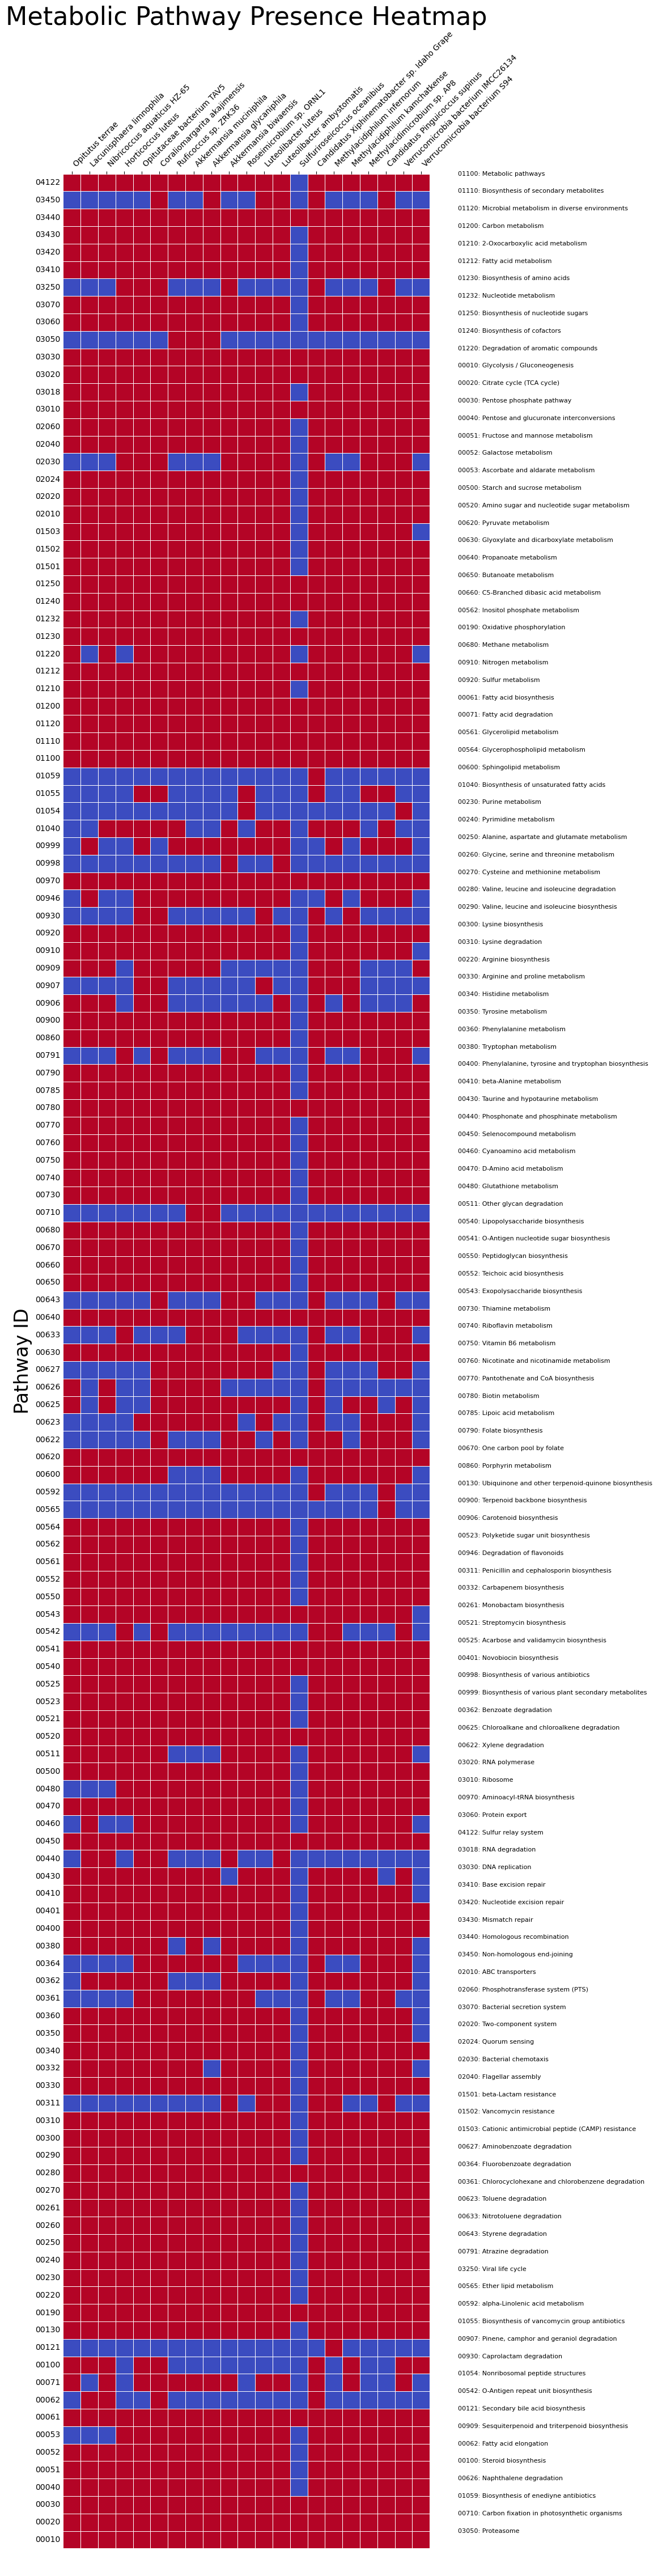

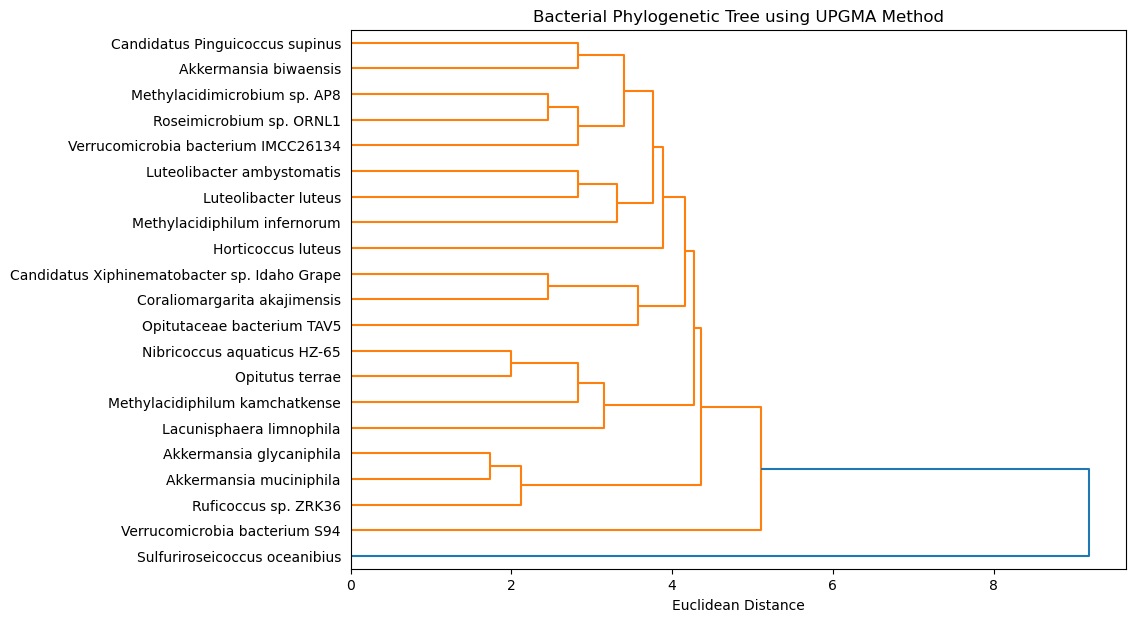

In [2]:
main('Verrucomicrobia', 'Verrucomicrobia.csv', 'Verrucomicrobia.pdf')
tree('Verrucomicrobia')

In [ ]:
main("Delftia", "Delftia.csv", "Delftia.pdf")
main("Rhodococcus", "Rhodococcus.csv", "Rhodococcus.pdf")
main("Vibrio", "Vibrio.csv", "Vibrio.pdf")

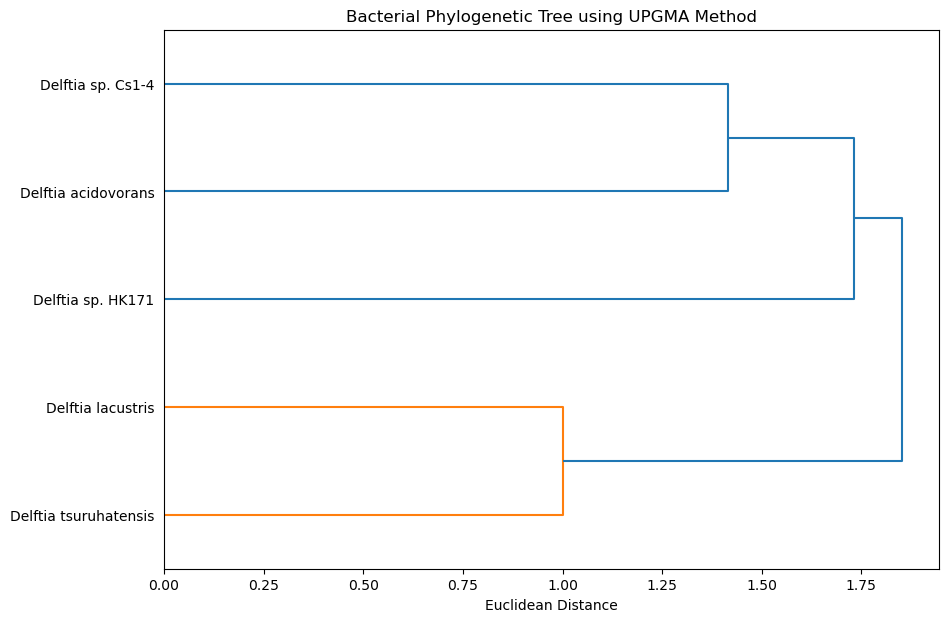

In [42]:
tree("Delftia")